## Demystifying Building Computer Vision Models using Azure AutoML
### AutoML: Train and Deploy an Object Detection model in 7 Steps!
* https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models

* https://github.com/Azure/azureml-examples/tree/sdk-preview/cli/jobs/automl-standalone-jobs

#### Steps:
##### 1. Connect to Azure Machine Learning Workspace
##### 2. Grab your Training Data and create your JSONL and MLTable(s)
##### 3. Create your Compute so you can train your data
##### 4. Configure and run the AutoML for Images Object Detection training job
##### 5. Using MFLow Retrieve the Best Trial (Best Model's trial/run)
##### 6. Register best Model and Deploy  
##### 7. Test: Visualize Detections

#### 1. Connect to Azure Machine Learning Workspace
###### 1.1. Import the required libraries

In [ ]:
# Import required libraries
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential # Authentication package
from azure.identity import AzureCliCredential
from azure.ai.ml import automl, Input, MLClient, VERSION

from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.automl import (
    ClassificationPrimaryMetrics, #Multi-class image classification
    ClassificationMultilabelPrimaryMetrics, #Multi-Label image classification
    ObjectDetectionPrimaryMetrics, #Object Detection
    InstanceSegmentationPrimaryMetrics, #Instance Segementation
)

print ('azure.ai.ml: ' + VERSION)

In [ ]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

ml_client = MLClient.from_config(credential)

#### 2. MLTable with input Training Data
##### 2.1. Download the Data

In [ ]:
import os
import urllib
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = "./data"

# create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"

# Extract current dataset name from dataset url
dataset_name = os.path.split(download_url)[-1].split(".")[0]
# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Download the dataset
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path=dataset_parent_dir)
    print("done")
# delete zip file
os.remove(data_file)

##### Checkout one of the sample images from this dataset:

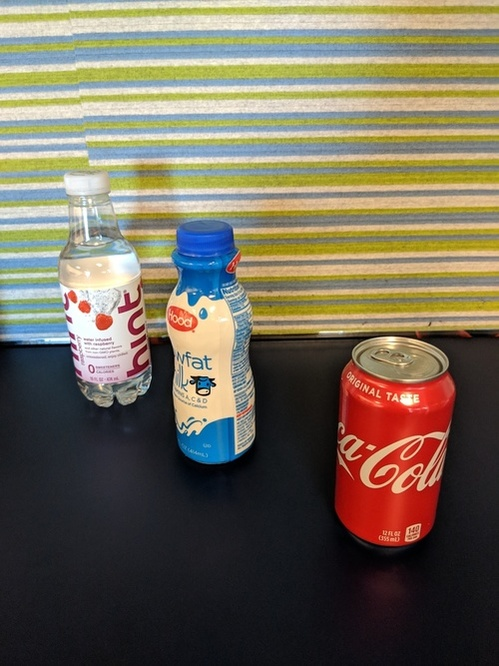

In [25]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images", "32.jpg")
Image(filename=sample_image)

##### 2.2. Upload images to the attached workspace Azure Storage Account

In [26]:
# Uploading image files by creating a 'data asset URI FOLDER':
# IMPORTANT: IF THIS CELL GIVES YOU AN ERROR IT IS MOST LIKELY BECAUSE THE USER OR 
# OR SERVICE PRINCIPAL DOES NOT HAVE THE APPROPRIATE PERMISSIONS.
# MAKE SURE YOUR USER HAS STORAGE BLOB DATA READER AND STORAGE BLOB DATA CONTRIBUTOR ROLES ASSIGNED.

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images Object detection",
    name="fridge-items-images-object-detection",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

# print(uri_folder_data_asset)
# print("")
# print("Path to folder in Blob Storage:")
# print(uri_folder_data_asset.path)

##### 2.3. Convert the downloaded data to JSONL

In [ ]:
import json
import os
import xml.etree.ElementTree as ET

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "image_details": {"format": None, "width": None, "height": None},
    "label": [],
}

# Path to the annotations
annotations_folder = os.path.join(dataset_dir, "annotations")

# Read each annotation and convert it to jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for i, filename in enumerate(os.listdir(annotations_folder)):
            if not filename.endswith(".xml"):
                print(f"Skipping unknown file: {filename}")
                continue

            annotation_filename = os.path.join(annotations_folder, filename)
            print(f"Parsing {annotation_filename}")

            root = ET.parse(annotation_filename).getroot()
            width = int(root.find("size/width").text)
            height = int(root.find("size/height").text)

            labels = []
            for object in root.findall("object"):
                name = object.find("name").text
                xmin = object.find("bndbox/xmin").text
                ymin = object.find("bndbox/ymin").text
                xmax = object.find("bndbox/xmax").text
                ymax = object.find("bndbox/ymax").text
                isCrowd = int(object.find("difficult").text)
                labels.append(
                    {
                        "label": name,
                        "topX": float(xmin) / width,
                        "topY": float(ymin) / height,
                        "bottomX": float(xmax) / width,
                        "bottomY": float(ymax) / height,
                        "isCrowd": isCrowd,
                    }
                )
            # build the jsonl file
            image_filename = root.find("filename").text
            _, file_extension = os.path.splitext(image_filename)
            json_line = dict(json_line_sample)
            json_line["image_url"] = json_line["image_url"] + "images/" + image_filename
            json_line["image_details"]["format"] = file_extension[1:]
            json_line["image_details"]["width"] = width
            json_line["image_details"]["height"] = height
            json_line["label"] = labels

            if i % train_validation_ratio == 0:
                # validation annotation
                validation_f.write(json.dumps(json_line) + "\n")
            else:
                # train annotation
                train_f.write(json.dumps(json_line) + "\n")

##### 2.4. Create MLTable file that will serve to pass in as your data input
###### Create MLTable data input using the jsonl files created above.

In [28]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Save train and validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [29]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

#### 3. Compute target setup

In [ ]:
#Please choose a VM type that is in the NC-family or the ND-family.
#CPU Compute is not supported for image and text dnn tasks. 
#To try serverless compute (preview), skip this step and proceed to Experiment setup down below.
#ALSO MAKE SURE TO ADD SYSTEM ASSIGNED OR USER ASSIGNED MANAGED IDENTITY TO THE CLUSTER AFTER ITS CREATED
#ALSO MAKE SURE THAT YOUR MANAGED IDENTITY HAS BLOB DATA STORAGE CONTRIBUTOR AND READER

from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=60,
        tier="Dedicated",
        min_instances=0,
        max_instances=2
    )
    ml_client.begin_create_or_update(compute_config).result()

#### 4. Configure and run the AutoML for Images Object Detection training job

In [35]:
# general job parameters
exp_name = "dpv2-image-object-detection-experiment"

In [36]:
# Create the AutoML job with the related factory-function.
from azure.ai.ml.entities import ResourceConfiguration

image_object_detection_job = automl.image_object_detection(
    compute=compute_name, #Comment out if you want to use serverless
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="mean_average_precision",
    tags={"my_custom_tag": "My custom value"},
)

#https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models?view=azureml-api-2&tabs=python#configure-your-object-detection-experiment
#To use serverless compute (preview), comment the line compute="compute_name" above and uncomment this code below:
#image_object_detection_job.resources = ResourceConfiguration(instance_type="Standard_NC24rs_v3",instance_count =1)

image_object_detection_job.set_limits(
    max_trials=10,
    max_concurrent_trials=2,
)

#### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [ ]:
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

#### 5. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

##### Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

##### Obtain the tracking URI for MLFlow

In [ ]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

In [ ]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")

In [16]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

##### Get the AutoML parent Job

In [ ]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

In [ ]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

##### Get the AutoML best child run

In [ ]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

##### Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [ ]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

##### Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [21]:
# Create local folder
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [ ]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

In [ ]:
import os

mlflow_model_dir = os.path.join(local_dir, "outputs", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

#### 6. Register best model and deploy
##### 6.1 Create managed online endpoint

In [25]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [ ]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime

online_endpoint_name = "od-fridge-items-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for deploying model",
    auth_mode="key",
    tags={"foo": "bar"},
)
print(online_endpoint_name)

In [ ]:
ml_client.begin_create_or_update(endpoint).result()

##### 6.2 Register best model and deploy

In [29]:
model_name = "od-fridge-items-mlflow-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="my sample object detection model",
    type=AssetTypes.MLFLOW_MODEL,
)

# for downloaded file
# model = Model(
#     path=mlflow_model_dir,
#     name=model_name,
#     description="my sample object detection model",
#     type=AssetTypes.MLFLOW_MODEL,
# )

registered_model = ml_client.models.create_or_update(model)

In [ ]:
registered_model.id

##### Deploy

In [31]:
deployment = ManagedOnlineDeployment(
    name="od-fridge-items-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS3_V2",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

In [ ]:
# od fridge items deployment to take 100% traffic
endpoint.traffic = {"od-fridge-items-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

##### Get endpoint details

In [ ]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

##### Test the deployment

In [57]:
# Create request json
import base64

sample_image = os.path.join(dataset_dir, "images", "11.jpg")


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

In [58]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [59]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

##### Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image.

carton: [54.714, 148.052, 153.114, 363.871], 0.999
water_bottle: [327.818, 179.57, 122.971, 322.926], 0.998


<Figure size 1296x864 with 0 Axes>

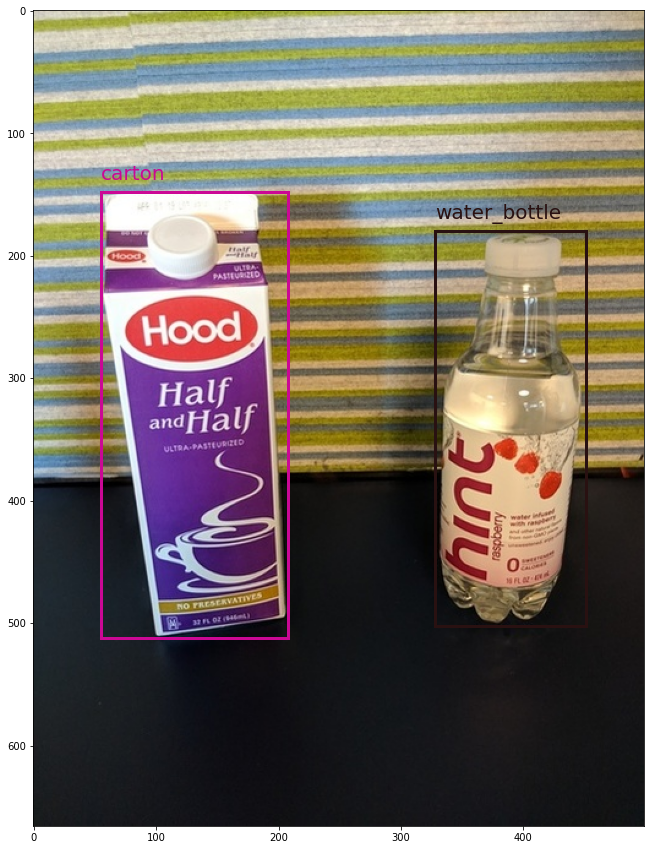

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = json.loads(resp)
for detect in detections[0]["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            f"{detect['label']}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
            f"{round(width, 3)}, {round(height, 3)}], {round(conf_score, 3)}"
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()